# 分类蔬菜和水果

目标：创建CNN模型来分类蔬菜和水果，使用TensorFlow实现。

* [Tutorial 1](https://www.tensorflow.org/tutorials/images/classification)
* [Tutorial 2](https://www.tensorflow.org/tutorials/keras/classification)

In [3]:
import os

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

plt.style.use("ggplot")

# 数据清洗

原始图像数据集存在两个问题：

1. 存在损坏图像。
2. 使用Opencv读取png时有时候会出现警告：`libpng warning: iCCP: known incorrect sRGB profile`。因为图像的iCCP块中包含不正确或过时的 sRGB配置文件。与以前的版本相比，Libpng-1.6对ICC配置文件的检查更加严格。

如何处理？

1. 对于损坏的图像，需要删除。
2. 对于警告信息，如果该警告不会给应用程序带来问题，可以忽略它。在训练Tensorflow模型时，如果不想看到这些警告，可以使用`tf.logging.set_verbosity(tf.logging.ERROR)`，将日志级别设置为ERROR。也可以使用pngcrush等命令行工具删除PNG图像中的iCCP块.

参考：[How to handle incorrect sRGB profile?](https://stackoverflow.com/questions/22745076/libpng-warning-iccp-known-incorrect-srgb-profile?rq=2)

In [4]:
def delete_corrupted_images(directory: str) -> None:
    class_names = os.listdir(directory)
    for name in class_names:
        sub_dir = os.path.join(directory, name)
        if os.path.isdir(sub_dir):
            for image_file in os.listdir(sub_dir):
                image_path = os.path.join(sub_dir, image_file)
                try:
                    img = cv2.imread(image_path)
                    if img is None:
                        print(f"Deleting {image_path}")
                        os.remove(image_path)
                except:
                    print(f"Deleting {image_path}")
                    os.remove(image_path)

In [5]:
delete_corrupted_images("data/train")
delete_corrupted_images("data/validation")
delete_corrupted_images("data/test")

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Deleting data/train/bell pepper/Image_56.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

数据预处理

使用`image_dataset_from_directory`辅助函数来创建数据集。

图像必须以标准化格式存储，例如：

dataset_root_dir/
  - class_a/
    - 00001.png
    - 00002.png
  - class_b/
    - 00001.png
    - 00002.png
  - class_c/
    - 00001.png
    - 00002.png

问题：
* 什么时候进行标准化？
* 为什么要划分验证集？

In [2]:
train_set = tf.keras.utils.image_dataset_from_directory(
    directory="data/train",
    batch_size=32,
    image_size=(64, 64),
    validation_split=0,
    seed=123
)

val_set = tf.keras.utils.image_dataset_from_directory(
    directory="data/validation/",
    batch_size=32,
    image_size=(64, 64),
)

test_set = tf.keras.utils.image_dataset_from_directory(
    directory="data/test",
    batch_size=32,
    image_size=(64, 64)
)

Found 3115 files belonging to 36 classes.
Found 351 files belonging to 36 classes.
Found 359 files belonging to 36 classes.


In [3]:
class_names = train_set.class_names
print(class_names)

['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


定义模型架构

如何定义模型架构？

定义模型架构是指如何设计神经网络来解决当前的问题，这包括指定网络层的数量和类型，以及层与层之间的连接。

卷积神经网络：卷积层(convolutional layers) -> 池化层(pooling layers) -> 全部连接层(fully connected layers)

* 卷积层负责从输入图像中学习特征
* 池化层负责减少特征空间的维度大小
* 全部连接层根据学习到的模式来分类结果

可以通过调整卷积层和池化层的数量，以及它们的参数，来改变模型的性能。

如何理解卷积层，持仓层和全部连接层？包含哪些核心参数？如何根据需求来调整参数？

In [4]:
image_height = 64
image_width = 64
num_classes = len(class_names)

model = tf.keras.models.Sequential(
    [
        # Data augmentation
        tf.keras.layers.RandomFlip("horizontal", input_shape=(image_height, image_width, 3)),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
        
        # Stadardization
        tf.keras.layers.Rescaling(
            1.0 / 255, input_shape=(image_height, image_width, 3)
        ),

        # Convolutional layers, pooling layers
        tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        
        # Apply dropout to reduce overfitting
        tf.keras.layers.Dropout(0.2),

        # Fully connected layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(num_classes),
    ]
)

编译模型

指定优化器，损失函数和评估指标。

一般采用什么设置？最佳实践是什么？

In [5]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

查看模型

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 64, 64, 3)         0         
                                                                 
 random_rotation (RandomRot  (None, 64, 64, 3)         0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 64, 64, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 16)        0         
 D)                                                     

训练模型

* 如何确定epoch的数量？
* 如何加速运算？
* 如何使用GPU？

In [8]:
epochs = 10
history = model.fit(
    train_set, validation_data=val_set, epochs=epochs
)

Epoch 1/10


2023-10-22 15:34:21.359764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 49s - loss: 3.6455 - accuracy: 0.0234 

2023-10-22 15:34:25.919556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/98 [>.............................] - ETA: 43s - loss: 3.6318 - accuracy: 0.0260

2023-10-22 15:34:26.597258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:34:26.737706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 37s - loss: 3.6125 - accuracy: 0.0312

2023-10-22 15:34:27.657668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 33s - loss: 3.6063 - accuracy: 0.0312

2023-10-22 15:34:28.491051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/98 [===>..........................] - ETA: 28s - loss: 3.6009 - accuracy: 0.0352

2023-10-22 15:34:29.422158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 19s - loss: 3.5812 - accuracy: 0.0344

2023-10-22 15:34:32.274828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 18s - loss: 3.5812 - accuracy: 0.0353

2023-10-22 15:34:32.700169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


36/98 [==========>...................] - ETA: 17s - loss: 3.5719 - accuracy: 0.0425

2023-10-22 15:34:33.834872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


39/98 [==========>...................] - ETA: 16s - loss: 3.5647 - accuracy: 0.0441

2023-10-22 15:34:34.967149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/98 [============>.................] - ETA: 15s - loss: 3.5518 - accuracy: 0.0497

2023-10-22 15:34:36.178520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


46/98 [=============>................] - ETA: 15s - loss: 3.5436 - accuracy: 0.0510

2023-10-22 15:34:37.152324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


55/98 [===============>..............] - ETA: 12s - loss: 3.5157 - accuracy: 0.0545

2023-10-22 15:34:39.514618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


57/98 [================>.............] - ETA: 11s - loss: 3.5064 - accuracy: 0.0548

2023-10-22 15:34:39.917737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/98 [=================>............] - ETA: 10s - loss: 3.4979 - accuracy: 0.0561

2023-10-22 15:34:40.416520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


62/98 [=================>............] - ETA: 9s - loss: 3.4843 - accuracy: 0.0585 

2023-10-22 15:34:40.904815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


67/98 [===================>..........] - ETA: 8s - loss: 3.4632 - accuracy: 0.0625

2023-10-22 15:34:41.839059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:34:41.982489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


72/98 [=====================>........] - ETA: 6s - loss: 3.4433 - accuracy: 0.0651

2023-10-22 15:34:43.210882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/98 [======================>.......] - ETA: 5s - loss: 3.4206 - accuracy: 0.0685

2023-10-22 15:34:45.161950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:34:45.370525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


88/98 [=========================>....] - ETA: 2s - loss: 3.3639 - accuracy: 0.0788

2023-10-22 15:34:47.532781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


96/98 [============================>.] - ETA: 0s - loss: 3.3275 - accuracy: 0.0833

2023-10-22 15:34:51.407939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:34:51.750627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 31s 286ms/step - loss: 3.3237 - accuracy: 0.0835 - val_loss: 2.5812 - val_accuracy: 0.2336
Epoch 2/10


2023-10-22 15:34:52.091888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 50s - loss: 2.8314 - accuracy: 0.1719 

2023-10-22 15:34:56.653805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/98 [>.............................] - ETA: 44s - loss: 2.7939 - accuracy: 0.2031

2023-10-22 15:34:57.353197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:34:57.490627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 37s - loss: 2.7896 - accuracy: 0.1840

2023-10-22 15:34:58.414574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 33s - loss: 2.7738 - accuracy: 0.1693

2023-10-22 15:34:59.241868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/98 [===>..........................] - ETA: 28s - loss: 2.7509 - accuracy: 0.1699

2023-10-22 15:35:00.164149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 19s - loss: 2.7339 - accuracy: 0.1969

2023-10-22 15:35:03.017122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 18s - loss: 2.7159 - accuracy: 0.2026

2023-10-22 15:35:03.451749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


36/98 [==========>...................] - ETA: 17s - loss: 2.7249 - accuracy: 0.2014

2023-10-22 15:35:04.574337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


39/98 [==========>...................] - ETA: 16s - loss: 2.7301 - accuracy: 0.1971

2023-10-22 15:35:05.707362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/98 [============>.................] - ETA: 15s - loss: 2.7411 - accuracy: 0.1996

2023-10-22 15:35:06.913940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


46/98 [=============>................] - ETA: 15s - loss: 2.7351 - accuracy: 0.1990

2023-10-22 15:35:07.881430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


55/98 [===============>..............] - ETA: 12s - loss: 2.7155 - accuracy: 0.2068

2023-10-22 15:35:10.255239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


57/98 [================>.............] - ETA: 11s - loss: 2.7041 - accuracy: 0.2105

2023-10-22 15:35:10.652458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/98 [=================>............] - ETA: 10s - loss: 2.7009 - accuracy: 0.2113

2023-10-22 15:35:11.136725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


62/98 [=================>............] - ETA: 9s - loss: 2.6865 - accuracy: 0.2112 

2023-10-22 15:35:11.624995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


67/98 [===================>..........] - ETA: 8s - loss: 2.6735 - accuracy: 0.2118

2023-10-22 15:35:12.541500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:35:12.686687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


72/98 [=====================>........] - ETA: 6s - loss: 2.6705 - accuracy: 0.2122

2023-10-22 15:35:13.918266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/98 [======================>.......] - ETA: 5s - loss: 2.6644 - accuracy: 0.2179

2023-10-22 15:35:15.864368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


79/98 [=======================>......] - ETA: 5s - loss: 2.6624 - accuracy: 0.2195

2023-10-22 15:35:16.093123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


88/98 [=========================>....] - ETA: 2s - loss: 2.6581 - accuracy: 0.2191

2023-10-22 15:35:18.268010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - ETA: 0s - loss: 2.6466 - accuracy: 0.2170

2023-10-22 15:35:22.102092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:35:22.449631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 31s 286ms/step - loss: 2.6466 - accuracy: 0.2170 - val_loss: 2.2032 - val_accuracy: 0.3447
Epoch 3/10


2023-10-22 15:35:22.800204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 49s - loss: 2.3241 - accuracy: 0.3125 

2023-10-22 15:35:27.353075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/98 [>.............................] - ETA: 43s - loss: 2.3362 - accuracy: 0.3021

2023-10-22 15:35:28.034865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:35:28.173978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 37s - loss: 2.4324 - accuracy: 0.2743

2023-10-22 15:35:29.100544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 33s - loss: 2.4569 - accuracy: 0.2630

2023-10-22 15:35:29.937326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/98 [===>..........................] - ETA: 28s - loss: 2.4477 - accuracy: 0.2734

2023-10-22 15:35:30.879289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 19s - loss: 2.4665 - accuracy: 0.2677

2023-10-22 15:35:33.798345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 19s - loss: 2.4560 - accuracy: 0.2732

2023-10-22 15:35:34.233917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


36/98 [==========>...................] - ETA: 17s - loss: 2.4560 - accuracy: 0.2691

2023-10-22 15:35:35.360198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


39/98 [==========>...................] - ETA: 16s - loss: 2.4498 - accuracy: 0.2668

2023-10-22 15:35:36.489914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/98 [============>.................] - ETA: 15s - loss: 2.4413 - accuracy: 0.2649

2023-10-22 15:35:37.694713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


46/98 [=============>................] - ETA: 15s - loss: 2.4329 - accuracy: 0.2649

2023-10-22 15:35:38.666503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


55/98 [===============>..............] - ETA: 12s - loss: 2.4149 - accuracy: 0.2750

2023-10-22 15:35:41.058302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


57/98 [================>.............] - ETA: 11s - loss: 2.4105 - accuracy: 0.2758

2023-10-22 15:35:41.451794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/98 [=================>............] - ETA: 10s - loss: 2.4055 - accuracy: 0.2786

2023-10-22 15:35:41.948172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


62/98 [=================>............] - ETA: 9s - loss: 2.4137 - accuracy: 0.2747 

2023-10-22 15:35:42.442410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


67/98 [===================>..........] - ETA: 8s - loss: 2.4099 - accuracy: 0.2785

2023-10-22 15:35:43.386048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:35:43.528666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


72/98 [=====================>........] - ETA: 7s - loss: 2.4123 - accuracy: 0.2769

2023-10-22 15:35:44.752524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/98 [======================>.......] - ETA: 5s - loss: 2.3999 - accuracy: 0.2796

2023-10-22 15:35:46.710993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:35:46.919233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


88/98 [=========================>....] - ETA: 2s - loss: 2.3919 - accuracy: 0.2784

2023-10-22 15:35:49.088663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/98 [============================>.] - ETA: 0s - loss: 2.3871 - accuracy: 0.2777

2023-10-22 15:35:52.853542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:35:53.205924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 31s 287ms/step - loss: 2.3864 - accuracy: 0.2787 - val_loss: 1.9145 - val_accuracy: 0.3960
Epoch 4/10


2023-10-22 15:35:53.551219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 49s - loss: 2.1373 - accuracy: 0.3594 

2023-10-22 15:35:58.095492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/98 [>.............................] - ETA: 43s - loss: 2.2054 - accuracy: 0.3073

2023-10-22 15:35:58.775646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:35:58.919909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 37s - loss: 2.1794 - accuracy: 0.3194

2023-10-22 15:35:59.838299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 33s - loss: 2.1786 - accuracy: 0.3359

2023-10-22 15:36:00.669441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/98 [===>..........................] - ETA: 28s - loss: 2.1848 - accuracy: 0.3301

2023-10-22 15:36:01.596695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 19s - loss: 2.2439 - accuracy: 0.3177

2023-10-22 15:36:04.460360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 18s - loss: 2.2517 - accuracy: 0.3196

2023-10-22 15:36:04.889784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


36/98 [==========>...................] - ETA: 17s - loss: 2.2550 - accuracy: 0.3142

2023-10-22 15:36:06.013955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


39/98 [==========>...................] - ETA: 16s - loss: 2.2595 - accuracy: 0.3077

2023-10-22 15:36:07.153559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/98 [============>.................] - ETA: 15s - loss: 2.2505 - accuracy: 0.3089

2023-10-22 15:36:08.368987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


45/98 [============>.................] - ETA: 15s - loss: 2.2481 - accuracy: 0.3090

2023-10-22 15:36:09.337659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


55/98 [===============>..............] - ETA: 12s - loss: 2.2381 - accuracy: 0.3182

2023-10-22 15:36:11.706100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


57/98 [================>.............] - ETA: 11s - loss: 2.2440 - accuracy: 0.3169

2023-10-22 15:36:12.104387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/98 [=================>............] - ETA: 10s - loss: 2.2384 - accuracy: 0.3167

2023-10-22 15:36:12.604045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


62/98 [=================>............] - ETA: 9s - loss: 2.2434 - accuracy: 0.3160 

2023-10-22 15:36:13.096504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


67/98 [===================>..........] - ETA: 8s - loss: 2.2457 - accuracy: 0.3172

2023-10-22 15:36:14.039882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:36:14.176375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


72/98 [=====================>........] - ETA: 6s - loss: 2.2429 - accuracy: 0.3168

2023-10-22 15:36:15.413043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/98 [======================>.......] - ETA: 5s - loss: 2.2447 - accuracy: 0.3177

2023-10-22 15:36:17.346675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


79/98 [=======================>......] - ETA: 5s - loss: 2.2514 - accuracy: 0.3157

2023-10-22 15:36:17.565472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


88/98 [=========================>....] - ETA: 2s - loss: 2.2532 - accuracy: 0.3182

2023-10-22 15:36:19.720658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - ETA: 0s - loss: 2.2434 - accuracy: 0.3210

2023-10-22 15:36:23.503675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:36:23.853099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 31s 286ms/step - loss: 2.2434 - accuracy: 0.3210 - val_loss: 1.8200 - val_accuracy: 0.4330
Epoch 5/10


2023-10-22 15:36:24.199861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 49s - loss: 2.2381 - accuracy: 0.3281 

2023-10-22 15:36:28.752983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/98 [>.............................] - ETA: 43s - loss: 2.2734 - accuracy: 0.3021

2023-10-22 15:36:29.434482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:36:29.575213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 37s - loss: 2.1956 - accuracy: 0.3229

2023-10-22 15:36:30.502782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 33s - loss: 2.1555 - accuracy: 0.3177

2023-10-22 15:36:31.342016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/98 [===>..........................] - ETA: 28s - loss: 2.1606 - accuracy: 0.3281

2023-10-22 15:36:32.281081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 19s - loss: 2.1650 - accuracy: 0.3354

2023-10-22 15:36:35.138027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 18s - loss: 2.1728 - accuracy: 0.3276

2023-10-22 15:36:35.581253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


36/98 [==========>...................] - ETA: 17s - loss: 2.1757 - accuracy: 0.3290

2023-10-22 15:36:36.711778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


39/98 [==========>...................] - ETA: 16s - loss: 2.1548 - accuracy: 0.3357

2023-10-22 15:36:37.847866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/98 [============>.................] - ETA: 15s - loss: 2.1605 - accuracy: 0.3416

2023-10-22 15:36:39.067794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


46/98 [=============>................] - ETA: 15s - loss: 2.1523 - accuracy: 0.3451

2023-10-22 15:36:40.043108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


55/98 [===============>..............] - ETA: 12s - loss: 2.1396 - accuracy: 0.3511

2023-10-22 15:36:42.428139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


57/98 [================>.............] - ETA: 11s - loss: 2.1372 - accuracy: 0.3498

2023-10-22 15:36:42.840871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/98 [=================>............] - ETA: 10s - loss: 2.1333 - accuracy: 0.3533

2023-10-22 15:36:43.336912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


62/98 [=================>............] - ETA: 9s - loss: 2.1413 - accuracy: 0.3523 

2023-10-22 15:36:43.825342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


67/98 [===================>..........] - ETA: 8s - loss: 2.1466 - accuracy: 0.3517

2023-10-22 15:36:44.761352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:36:44.900144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


72/98 [=====================>........] - ETA: 6s - loss: 2.1469 - accuracy: 0.3533

2023-10-22 15:36:46.117350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/98 [======================>.......] - ETA: 5s - loss: 2.1494 - accuracy: 0.3502

2023-10-22 15:36:48.088613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:36:48.297427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


88/98 [=========================>....] - ETA: 2s - loss: 2.1532 - accuracy: 0.3455

2023-10-22 15:36:50.449817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - ETA: 0s - loss: 2.1455 - accuracy: 0.3445

2023-10-22 15:36:54.237175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:36:54.588369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 31s 286ms/step - loss: 2.1455 - accuracy: 0.3445 - val_loss: 1.7067 - val_accuracy: 0.4359
Epoch 6/10


2023-10-22 15:36:54.933121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 49s - loss: 2.0404 - accuracy: 0.3359 

2023-10-22 15:36:59.518509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/98 [>.............................] - ETA: 43s - loss: 2.0580 - accuracy: 0.3438

2023-10-22 15:37:00.193700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:37:00.335548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


10/98 [==>...........................] - ETA: 35s - loss: 2.0528 - accuracy: 0.3469

2023-10-22 15:37:01.253001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 33s - loss: 2.0814 - accuracy: 0.3464

2023-10-22 15:37:02.082947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/98 [===>..........................] - ETA: 28s - loss: 2.1038 - accuracy: 0.3516

2023-10-22 15:37:03.019676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 19s - loss: 2.0892 - accuracy: 0.3583

2023-10-22 15:37:05.913119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 19s - loss: 2.0853 - accuracy: 0.3599

2023-10-22 15:37:06.357130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


36/98 [==========>...................] - ETA: 17s - loss: 2.0706 - accuracy: 0.3611

2023-10-22 15:37:07.485987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


39/98 [==========>...................] - ETA: 16s - loss: 2.0684 - accuracy: 0.3566

2023-10-22 15:37:08.627576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/98 [============>.................] - ETA: 15s - loss: 2.0783 - accuracy: 0.3523

2023-10-22 15:37:09.835346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


45/98 [============>.................] - ETA: 15s - loss: 2.0787 - accuracy: 0.3542

2023-10-22 15:37:10.803000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


55/98 [===============>..............] - ETA: 12s - loss: 2.0702 - accuracy: 0.3625

2023-10-22 15:37:13.186065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


57/98 [================>.............] - ETA: 11s - loss: 2.0649 - accuracy: 0.3635

2023-10-22 15:37:13.594858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/98 [=================>............] - ETA: 10s - loss: 2.0612 - accuracy: 0.3649

2023-10-22 15:37:14.091347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


62/98 [=================>............] - ETA: 9s - loss: 2.0642 - accuracy: 0.3639 

2023-10-22 15:37:14.594331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


67/98 [===================>..........] - ETA: 8s - loss: 2.0619 - accuracy: 0.3661

2023-10-22 15:37:15.524639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:37:15.668267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


72/98 [=====================>........] - ETA: 7s - loss: 2.0572 - accuracy: 0.3685

2023-10-22 15:37:16.896985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/98 [======================>.......] - ETA: 5s - loss: 2.0763 - accuracy: 0.3662

2023-10-22 15:37:18.853392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:37:19.064036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


88/98 [=========================>....] - ETA: 2s - loss: 2.0615 - accuracy: 0.3700

2023-10-22 15:37:21.229234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - ETA: 0s - loss: 2.0526 - accuracy: 0.3711

2023-10-22 15:37:25.036786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:37:25.379774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 31s 287ms/step - loss: 2.0526 - accuracy: 0.3711 - val_loss: 1.4836 - val_accuracy: 0.5157
Epoch 7/10


2023-10-22 15:37:25.729547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 49s - loss: 1.8651 - accuracy: 0.4062 

2023-10-22 15:37:30.309307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/98 [>.............................] - ETA: 43s - loss: 1.9063 - accuracy: 0.3750

2023-10-22 15:37:30.999318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:37:31.142503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 37s - loss: 1.9070 - accuracy: 0.3958

2023-10-22 15:37:32.060240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 33s - loss: 1.8555 - accuracy: 0.4062

2023-10-22 15:37:32.892923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/98 [===>..........................] - ETA: 28s - loss: 1.9148 - accuracy: 0.4004

2023-10-22 15:37:33.819076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 19s - loss: 1.9946 - accuracy: 0.3833

2023-10-22 15:37:36.695832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 18s - loss: 1.9914 - accuracy: 0.3810

2023-10-22 15:37:37.133712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


36/98 [==========>...................] - ETA: 17s - loss: 1.9951 - accuracy: 0.3845

2023-10-22 15:37:38.259200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


39/98 [==========>...................] - ETA: 16s - loss: 2.0031 - accuracy: 0.3846

2023-10-22 15:37:39.401961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/98 [============>.................] - ETA: 15s - loss: 1.9875 - accuracy: 0.3885

2023-10-22 15:37:40.635488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


45/98 [============>.................] - ETA: 15s - loss: 1.9921 - accuracy: 0.3875

2023-10-22 15:37:41.616382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


55/98 [===============>..............] - ETA: 12s - loss: 1.9721 - accuracy: 0.3892

2023-10-22 15:37:44.037737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


57/98 [================>.............] - ETA: 11s - loss: 1.9775 - accuracy: 0.3849

2023-10-22 15:37:44.447460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/98 [=================>............] - ETA: 10s - loss: 1.9770 - accuracy: 0.3840

2023-10-22 15:37:44.964489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


62/98 [=================>............] - ETA: 9s - loss: 1.9802 - accuracy: 0.3790 

2023-10-22 15:37:45.486497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


67/98 [===================>..........] - ETA: 8s - loss: 1.9754 - accuracy: 0.3829

2023-10-22 15:37:46.426935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:37:46.565823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


72/98 [=====================>........] - ETA: 7s - loss: 1.9718 - accuracy: 0.3824

2023-10-22 15:37:47.795741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/98 [======================>.......] - ETA: 5s - loss: 1.9812 - accuracy: 0.3818

2023-10-22 15:37:49.744533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


79/98 [=======================>......] - ETA: 5s - loss: 1.9845 - accuracy: 0.3821

2023-10-22 15:37:49.974138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


88/98 [=========================>....] - ETA: 2s - loss: 1.9705 - accuracy: 0.3864

2023-10-22 15:37:52.127318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - ETA: 0s - loss: 1.9604 - accuracy: 0.3897

2023-10-22 15:37:55.941664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:37:56.279780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 31s 288ms/step - loss: 1.9604 - accuracy: 0.3897 - val_loss: 1.4456 - val_accuracy: 0.5128
Epoch 8/10


2023-10-22 15:37:56.634272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 50s - loss: 1.9696 - accuracy: 0.3750 

2023-10-22 15:38:01.207269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/98 [>.............................] - ETA: 43s - loss: 1.9130 - accuracy: 0.3802

2023-10-22 15:38:01.887651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:38:02.025949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 37s - loss: 1.9928 - accuracy: 0.3646

2023-10-22 15:38:02.963430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 33s - loss: 2.0271 - accuracy: 0.3828

2023-10-22 15:38:03.803080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/98 [===>..........................] - ETA: 28s - loss: 1.9848 - accuracy: 0.3887

2023-10-22 15:38:04.738159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 19s - loss: 1.9665 - accuracy: 0.3875

2023-10-22 15:38:07.609084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 19s - loss: 1.9498 - accuracy: 0.3942

2023-10-22 15:38:08.041335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


36/98 [==========>...................] - ETA: 17s - loss: 1.9670 - accuracy: 0.3863

2023-10-22 15:38:09.167687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


39/98 [==========>...................] - ETA: 16s - loss: 1.9676 - accuracy: 0.3862

2023-10-22 15:38:10.312961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/98 [============>.................] - ETA: 15s - loss: 1.9924 - accuracy: 0.3857

2023-10-22 15:38:11.527874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


45/98 [============>.................] - ETA: 15s - loss: 1.9894 - accuracy: 0.3819

2023-10-22 15:38:12.508953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


55/98 [===============>..............] - ETA: 12s - loss: 1.9551 - accuracy: 0.3949

2023-10-22 15:38:14.890731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


57/98 [================>.............] - ETA: 11s - loss: 1.9491 - accuracy: 0.3964

2023-10-22 15:38:15.292770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/98 [=================>............] - ETA: 10s - loss: 1.9547 - accuracy: 0.3951

2023-10-22 15:38:15.801921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


62/98 [=================>............] - ETA: 9s - loss: 1.9514 - accuracy: 0.3952 

2023-10-22 15:38:16.307243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


67/98 [===================>..........] - ETA: 8s - loss: 1.9490 - accuracy: 0.3941

2023-10-22 15:38:17.233612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:38:17.374704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


72/98 [=====================>........] - ETA: 7s - loss: 1.9429 - accuracy: 0.3976

2023-10-22 15:38:18.608246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/98 [======================>.......] - ETA: 5s - loss: 1.9478 - accuracy: 0.4010

2023-10-22 15:38:20.542769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:38:20.758849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


88/98 [=========================>....] - ETA: 2s - loss: 1.9361 - accuracy: 0.4006

2023-10-22 15:38:22.919903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - ETA: 0s - loss: 1.9257 - accuracy: 0.4013

2023-10-22 15:38:26.714935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:38:27.069768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 31s 287ms/step - loss: 1.9257 - accuracy: 0.4013 - val_loss: 1.3223 - val_accuracy: 0.5783
Epoch 9/10


2023-10-22 15:38:27.422537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 50s - loss: 1.7650 - accuracy: 0.4531 

2023-10-22 15:38:32.002748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/98 [>.............................] - ETA: 44s - loss: 1.8018 - accuracy: 0.4583

2023-10-22 15:38:32.685361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:38:32.823382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 37s - loss: 1.8146 - accuracy: 0.4340

2023-10-22 15:38:33.744197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 33s - loss: 1.8373 - accuracy: 0.4557

2023-10-22 15:38:34.592462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/98 [===>..........................] - ETA: 29s - loss: 1.7938 - accuracy: 0.4590

2023-10-22 15:38:35.541440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 19s - loss: 1.7975 - accuracy: 0.4563

2023-10-22 15:38:38.431493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 19s - loss: 1.8001 - accuracy: 0.4567

2023-10-22 15:38:38.868602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


36/98 [==========>...................] - ETA: 17s - loss: 1.8215 - accuracy: 0.4531

2023-10-22 15:38:40.030592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


39/98 [==========>...................] - ETA: 16s - loss: 1.8332 - accuracy: 0.4439

2023-10-22 15:38:41.176974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/98 [============>.................] - ETA: 15s - loss: 1.8438 - accuracy: 0.4453

2023-10-22 15:38:42.384292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


45/98 [============>.................] - ETA: 15s - loss: 1.8429 - accuracy: 0.4431

2023-10-22 15:38:43.373661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


55/98 [===============>..............] - ETA: 12s - loss: 1.8169 - accuracy: 0.4483

2023-10-22 15:38:45.754782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


57/98 [================>.............] - ETA: 11s - loss: 1.8178 - accuracy: 0.4490

2023-10-22 15:38:46.161289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/98 [=================>............] - ETA: 10s - loss: 1.8109 - accuracy: 0.4513

2023-10-22 15:38:46.655236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


62/98 [=================>............] - ETA: 9s - loss: 1.8100 - accuracy: 0.4501 

2023-10-22 15:38:47.142461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


67/98 [===================>..........] - ETA: 8s - loss: 1.8275 - accuracy: 0.4436

2023-10-22 15:38:48.064818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:38:48.213736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


72/98 [=====================>........] - ETA: 7s - loss: 1.8353 - accuracy: 0.4379

2023-10-22 15:38:49.427310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/98 [======================>.......] - ETA: 5s - loss: 1.8303 - accuracy: 0.4395

2023-10-22 15:38:51.356815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


79/98 [=======================>......] - ETA: 5s - loss: 1.8295 - accuracy: 0.4399

2023-10-22 15:38:51.575518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


88/98 [=========================>....] - ETA: 2s - loss: 1.8348 - accuracy: 0.4375

2023-10-22 15:38:53.716331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - ETA: 0s - loss: 1.8320 - accuracy: 0.4360

2023-10-22 15:38:57.502089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:38:57.856704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 31s 287ms/step - loss: 1.8320 - accuracy: 0.4360 - val_loss: 1.2824 - val_accuracy: 0.5499
Epoch 10/10


2023-10-22 15:38:58.207931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 49s - loss: 1.7793 - accuracy: 0.4531 

2023-10-22 15:39:02.762211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/98 [>.............................] - ETA: 43s - loss: 1.7956 - accuracy: 0.4219

2023-10-22 15:39:03.438484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:39:03.582408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 37s - loss: 1.7959 - accuracy: 0.4375

2023-10-22 15:39:04.506057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 33s - loss: 1.7885 - accuracy: 0.4453

2023-10-22 15:39:05.352286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/98 [===>..........................] - ETA: 28s - loss: 1.7447 - accuracy: 0.4590

2023-10-22 15:39:06.292211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 19s - loss: 1.7903 - accuracy: 0.4667

2023-10-22 15:39:09.190451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 19s - loss: 1.7811 - accuracy: 0.4688

2023-10-22 15:39:09.622768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


36/98 [==========>...................] - ETA: 17s - loss: 1.7747 - accuracy: 0.4688

2023-10-22 15:39:10.744371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


39/98 [==========>...................] - ETA: 16s - loss: 1.7858 - accuracy: 0.4607

2023-10-22 15:39:11.885479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/98 [============>.................] - ETA: 15s - loss: 1.7806 - accuracy: 0.4602

2023-10-22 15:39:13.104834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


45/98 [============>.................] - ETA: 15s - loss: 1.7756 - accuracy: 0.4604

2023-10-22 15:39:14.088510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


55/98 [===============>..............] - ETA: 12s - loss: 1.7561 - accuracy: 0.4642

2023-10-22 15:39:16.460404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


57/98 [================>.............] - ETA: 11s - loss: 1.7606 - accuracy: 0.4594

2023-10-22 15:39:16.858882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/98 [=================>............] - ETA: 10s - loss: 1.7580 - accuracy: 0.4592

2023-10-22 15:39:17.364790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


62/98 [=================>............] - ETA: 9s - loss: 1.7676 - accuracy: 0.4561 

2023-10-22 15:39:17.864696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


67/98 [===================>..........] - ETA: 8s - loss: 1.7801 - accuracy: 0.4524

2023-10-22 15:39:18.786060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:39:18.921238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


72/98 [=====================>........] - ETA: 7s - loss: 1.7808 - accuracy: 0.4531

2023-10-22 15:39:20.156538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


78/98 [======================>.......] - ETA: 5s - loss: 1.7819 - accuracy: 0.4539

2023-10-22 15:39:22.122691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:39:22.338689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


88/98 [=========================>....] - ETA: 2s - loss: 1.7755 - accuracy: 0.4553

2023-10-22 15:39:24.506531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - ETA: 0s - loss: 1.7733 - accuracy: 0.4526

2023-10-22 15:39:28.288384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-22 15:39:28.636860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 31s 287ms/step - loss: 1.7733 - accuracy: 0.4526 - val_loss: 1.2232 - val_accuracy: 0.5983


可视化训练结果

如何评估过拟合？

* 如果训练集的预测精度显著高于验证集，表明过度拟合。
* 当训练集数量过少，模型有时候会从数据中学习到噪音或者不必要的模式，这也会导致过拟合。
* 防止过拟合的两种方式：1. 数据扩充（data augmentation）；2. 正则化（regularization）。

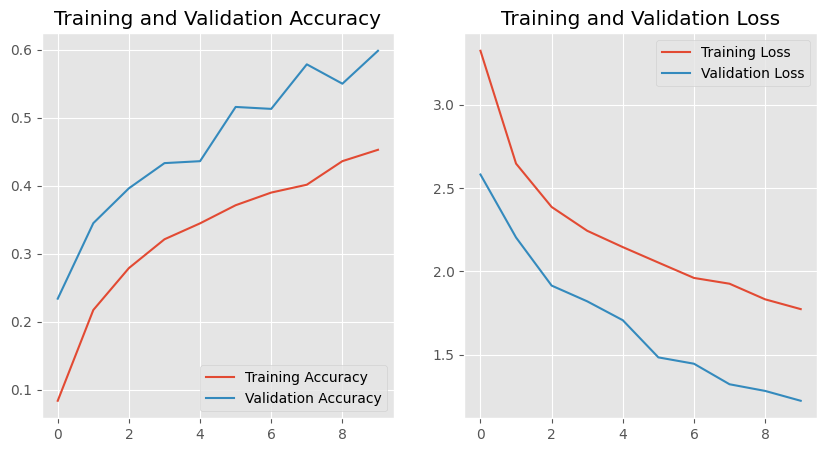

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

检验预测能力

In [13]:
# Evaluate the model
loss, accuracy = model.evaluate(test_set)
print(f"Loss: {loss:.2f}")
print(f"Accuracy: {accuracy:.2%}")

2023-10-22 15:44:28.612805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 1/12 [=>............................] - ETA: 29s - loss: 1.2356 - accuracy: 0.6250

2023-10-22 15:44:30.824133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 4s 100ms/step - loss: 1.2192 - accuracy: 0.6017
Loss: 1.22
Accuracy: 60.17%
